# Data Analytics Assignment


## Cloud Wars - What should IBM do to become a leader and not be a niche player.

In [31]:
!pip install numpy pandas matplotlib statsmodels scikit-learn prettytable seaborn xlrd

In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY
from pathlib import Path

These are paths to all the income statements. <br>
Change them if you are using your own paths.

In [33]:
# incomestatements_pwd = "/content/drive/MyDrive/Assessment Data/DataAnalytics/CloudData/IncomeStatements/"
# balancesheets_pwd = "/content/drive/MyDrive/Assessment Data/DataAnalytics/CloudData/BalanceSheets/"

incomestatements_pwd = Path('./Data/IncomeStatements/')
balancesheets_pwd = Path('./Data/BalanceSheets/')

#### Income Statements Read ####
alibaba_is_df =  pd.read_excel(incomestatements_pwd / 'SPGlobal_AlibabaGroupHoldingLimited_IncomeStatement.xls', skiprows = 12)
alphabet_is_df = pd.read_excel(incomestatements_pwd / 'SPGlobal_AlphabetInc._IncomeStatement.xls', skiprows = 12)
amazon_is_df = pd.read_excel(incomestatements_pwd / 'SPGlobal_Amazon.comInc._IncomeStatement.xls', skiprows = 12)
ibm_is_df = pd.read_excel(incomestatements_pwd / 'SPGlobal_InternationalBusinessMachinesCorporation_IncomeStatement.xls', skiprows = 12)
msft_is_df = pd.read_excel(incomestatements_pwd / 'SPGlobal_MicrosoftCorporation_IncomeStatement.xls', skiprows = 12)
oracle_is_df = pd.read_excel(incomestatements_pwd / 'SPGlobal_OracleCorporation_IncomeStatement.xls', skiprows = 12)
tencent_is_df = pd.read_excel(incomestatements_pwd / 'SPGlobal_TencentHoldingsLimited_IncomeStatement.xls', skiprows = 12)

#### Balance Sheets Read ####
alibaba_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_AlibabaGroupHoldingLimited_BalanceSheet.xls', skiprows = 12)
alphabet_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_AlphabetInc._BalanceSheet.xls', skiprows = 12)
amazon_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_Amazon.comInc._BalanceSheet.xls', skiprows = 12)
ibm_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_InternationalBusinessMachinesCorporation_BalanceSheet.xls', skiprows = 12)
msft_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_MicrosoftCorporation_BalanceSheet.xls', skiprows = 12)
oracle_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_OracleCorporation_BalanceSheet.xls', skiprows = 12)
tencent_bs_df = pd.read_excel(balancesheets_pwd / 'SPGlobal_TencentHoldingsLimited_BalanceSheet.xls', skiprows = 12)

## Data Preprocessing and Cleaning
*Preprocessing:*<br>
All income statements and balance sheets were combined into their respective dictionaries. <br>
From the income statement, the following parameters were taken:
* Advertising Expense
* R&D Expense
* Selling and Marketing Expense
* Gross Profit
* Net Income
* Total Revenue

From the balance statement, the Full Time Employees parameter was taken.<br>

All these parameters were transposed, and given appropriate names to be used in further analysis. <br>


*Cleaning:*<br>
* Renamed `'Recommended: S&P Capital IQ - Standard'` as `Year`
* Converted `Years` column to `int`
* Added Company Name column
* Renamed `R&D_Expense` as `RD_Expense`
* Added the missing value of Number of Employees for Alibaba in 2012.



In [34]:
def data_pipeline(is_df, bs_df, company_name):
  ### Preprocessing Income Statement ###
  is_df.rename(columns={'Recommended: S&P Capital IQ - Standard': 'Year'},inplace=True)
  is_df = is_df.set_index('Year').transpose()
  is_df.index = is_df.index.str.replace('FY', '')
  is_df.columns = is_df.columns.str.strip()
  is_df = is_df[['Advertising Expense','R&D Expense', 'Selling and Marketing Expense', 'Gross Profit','Net Income', 'Total Revenue']]
  is_df.columns = is_df.columns.str.replace(' ', '_')
  is_df = is_df.astype(float)

  ### Preprocessing Balance Sheet ###
  bs_df.rename(columns={'Recommended: S&P Capital IQ - Standard': 'Year'},inplace=True)
  bs_df = bs_df.set_index('Year').transpose()
  bs_df.index = bs_df.index.str.replace('FY', '')
  bs_df.columns = bs_df.columns.str.strip()
  bs_df = bs_df[['Full Time Employees (actual)']]

  ### Appending number of employees to actual DF ###
  is_df['No_of_Employees'] = bs_df['Full Time Employees (actual)']
  is_df['Company'] = company_name
  is_df.reset_index(inplace=True)
  is_df.rename(columns={'index': 'Years'}, inplace=True)

  return is_df

In [35]:
income_statements = { 'Alibaba' : alibaba_is_df,
                      'Google': alphabet_is_df,
                      'Amazon': amazon_is_df,
                      'IBM' : ibm_is_df,
                      'Microsoft' : msft_is_df,
                      'Oracle' : oracle_is_df,
                      'Tencent' : tencent_is_df
}
balance_sheets = {  'Alibaba' : alibaba_bs_df,
                    'Google': alphabet_bs_df,
                    'Amazon': amazon_bs_df,
                    'IBM' : ibm_bs_df,
                    'Microsoft' : msft_bs_df,
                    'Oracle' : oracle_bs_df,
                    'Tencent' : tencent_bs_df
}

final_df = pd.DataFrame()


def data_pp_clean():
  # Preprocessing
  final_list = []
  for key, value in income_statements.items():
    temp_df = data_pipeline(value,balance_sheets[key],key)
    final_list.append(temp_df)
  final_df = pd.concat(final_list)

  # Cleaning
  final_df['Years']=final_df['Years'].astype('int64')
  final_df.rename(columns={'R&D_Expense': 'RD_Expense'},inplace=True)
  final_df.loc[(final_df['Years'] == 2012) & (final_df['Company'] == 'Alibaba'),'No_of_Employees'] = 21930 # Assigning Alibaba number of employees
  #Assigning advertising expenses for Amazon for years 2016 to 2022
  final_df.loc[(final_df['Years'] == 2016) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 5000000
  final_df.loc[(final_df['Years'] == 2017) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 6300000
  final_df.loc[(final_df['Years'] == 2018) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 8200000
  final_df.loc[(final_df['Years'] == 2019) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 11000000
  final_df.loc[(final_df['Years'] == 2020) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 10900000
  final_df.loc[(final_df['Years'] == 2021) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 16900000
  final_df.loc[(final_df['Years'] == 2022) & (final_df['Company'] == 'Amazon'),'Advertising_Expense'] = 20600000
  #final_df = final_df*1000
  final_df.iloc[:,1:8] = final_df.iloc[:,1:8] * 1000
  final_df = final_df.fillna(0)

  return final_df


final_df = data_pp_clean()

## Final DataFrame and DataFrame info.

In [36]:
final_df

Year,Years,Advertising_Expense,RD_Expense,Selling_and_Marketing_Expense,Gross_Profit,Net_Income,Total_Revenue,No_of_Employees,Company
0,2012,1.466427e+08,4.529041e+08,4.780741e+08,2.105996e+09,6.609867e+08,3.130619e+09,21930000,Alibaba
1,2013,2.085995e+08,5.967028e+08,5.744437e+08,3.942722e+09,1.356533e+09,5.487980e+09,20674000,Alibaba
2,2014,3.304413e+08,8.323134e+08,7.427576e+08,6.395559e+09,3.810207e+09,8.580361e+09,22072000,Alibaba
3,2015,6.602504e+08,1.720525e+09,1.374257e+09,8.454111e+09,3.916463e+09,1.230164e+10,34985000,Alibaba
4,2016,8.690152e+08,2.169077e+09,1.778775e+09,1.050684e+10,1.124182e+10,1.591144e+10,36446000,Alibaba
...,...,...,...,...,...,...,...,...,...
5,2017,0.000000e+00,2.583708e+09,2.612719e+09,1.730638e+10,1.058438e+10,3.519148e+10,44796000,Tencent
6,2018,0.000000e+00,3.472360e+09,3.668717e+09,2.151603e+10,1.191754e+10,4.733982e+10,54309000,Tencent
7,2019,0.000000e+00,4.399934e+09,3.098068e+09,2.426559e+10,1.351097e+10,5.463016e+10,62885000,Tencent
8,2020,3.857269e+09,5.652185e+09,4.895988e+09,3.214256e+10,2.318292e+10,6.991468e+10,85858000,Tencent


In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Years                          76 non-null     int64  
 1   Advertising_Expense            76 non-null     float64
 2   RD_Expense                     76 non-null     float64
 3   Selling_and_Marketing_Expense  76 non-null     float64
 4   Gross_Profit                   76 non-null     float64
 5   Net_Income                     76 non-null     float64
 6   Total_Revenue                  76 non-null     float64
 7   No_of_Employees                76 non-null     int64  
 8   Company                        76 non-null     object 
dtypes: float64(6), int64(2), object(1)
memory usage: 5.9+ KB


## Computing mean dataframe
* Mean of all values are computed, as they are to compared with IBM and Amazon.
* Amazon and IBM dataframes are seperated.

In [38]:
mean_df = final_df.groupby('Years')
mean_df = mean_df.mean(numeric_only=True)
mean_df = mean_df.reset_index()

amazon_df = final_df[final_df['Company'] == "Amazon"]
ibm_df = final_df[final_df['Company'] == "IBM"]

plt.rcParams['figure.figsize'] = (20,10)

In [39]:
amazon_df

Year,Years,Advertising_Expense,RD_Expense,Selling_and_Marketing_Expense,Gross_Profit,Net_Income,Total_Revenue,No_of_Employees,Company
0,2012,2.000000e+09,3.270000e+08,2.408000e+09,1.512200e+10,-3.900000e+07,6.109300e+10,88400000,Amazon
1,2013,2.400000e+09,4.510000e+08,3.133000e+09,2.027100e+10,2.740000e+08,7.445200e+10,117300000,Amazon
2,2014,3.300000e+09,5.590000e+08,4.332000e+09,2.623600e+10,-2.410000e+08,8.898800e+10,154100000,Amazon
3,2015,3.800000e+09,6.350000e+08,5.254000e+09,3.535500e+10,5.960000e+08,1.070060e+11,230800000,Amazon
4,2016,5.000000e+09,1.608500e+10,7.233000e+09,4.772200e+10,2.371000e+09,1.359870e+11,341400000,Amazon
5,2017,6.300000e+09,2.262000e+10,1.006900e+10,6.593200e+10,3.033000e+09,1.778660e+11,566000000,Amazon
6,2018,8.200000e+09,2.883700e+10,1.381400e+10,9.373100e+10,1.007300e+10,2.328870e+11,647500000,Amazon
7,2019,1.100000e+10,3.593100e+10,1.887800e+10,1.149860e+11,1.158800e+10,2.805220e+11,798000000,Amazon
8,2020,1.090000e+10,4.274000e+10,2.200800e+10,1.527570e+11,2.133100e+10,3.860640e+11,1298000000,Amazon
9,2021,1.690000e+10,5.605200e+10,3.255100e+10,1.974780e+11,3.336400e+10,4.698220e+11,1608000000,Amazon


## Competitor Analysis

### Total Revenue
Revenue, often referred to as sales or the top line, is the money received from normal business operations.

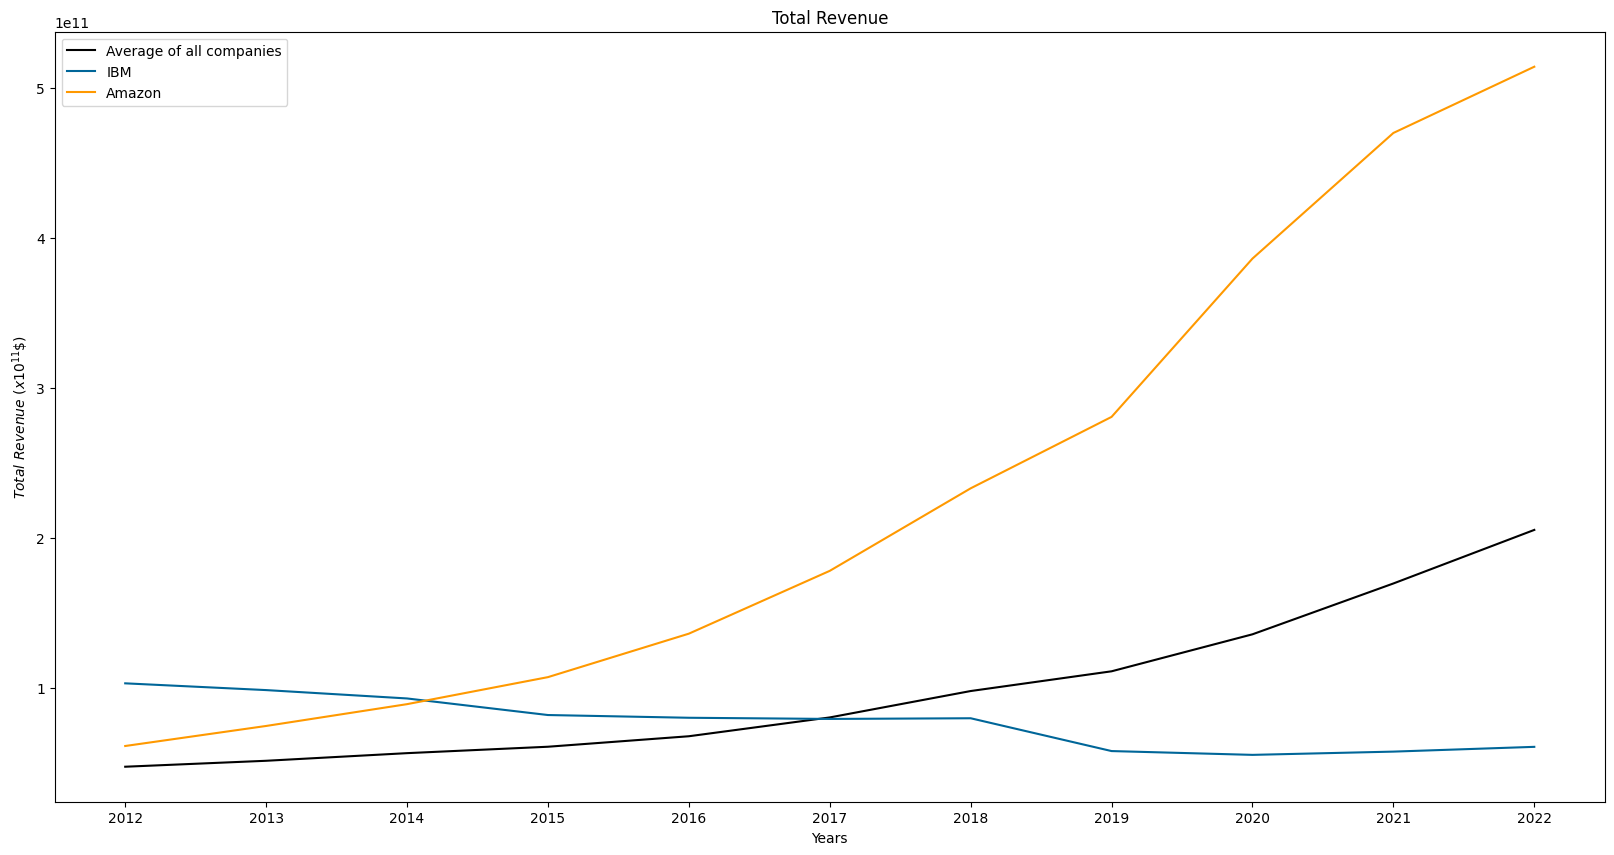

In [40]:
# Total Revenue
revenue_ax = sns.lineplot(x = 'Years', y = 'Total_Revenue', data = mean_df[['Years','Total_Revenue']], label = 'Average of all companies', color = 'black')
revenue_ax = sns.lineplot(x = 'Years', y = 'Total_Revenue', data = ibm_df[['Years','Total_Revenue']], label = 'IBM', color = '#006699')
revenue_ax = sns.lineplot(x = 'Years', y = 'Total_Revenue', data = amazon_df[['Years','Total_Revenue']], label = 'Amazon', color = '#FF9900')
revenue_ax.set(xticks = mean_df['Years'], title = 'Total Revenue', xlabel = 'Years', ylabel = "$Total\ Revenue\ (x10^{11}\$)$")
revenue_ax.legend()
plt.show()

### Net Income
Net income includes all of the costs and expenses that a company incurs, which are subtracted from revenue.

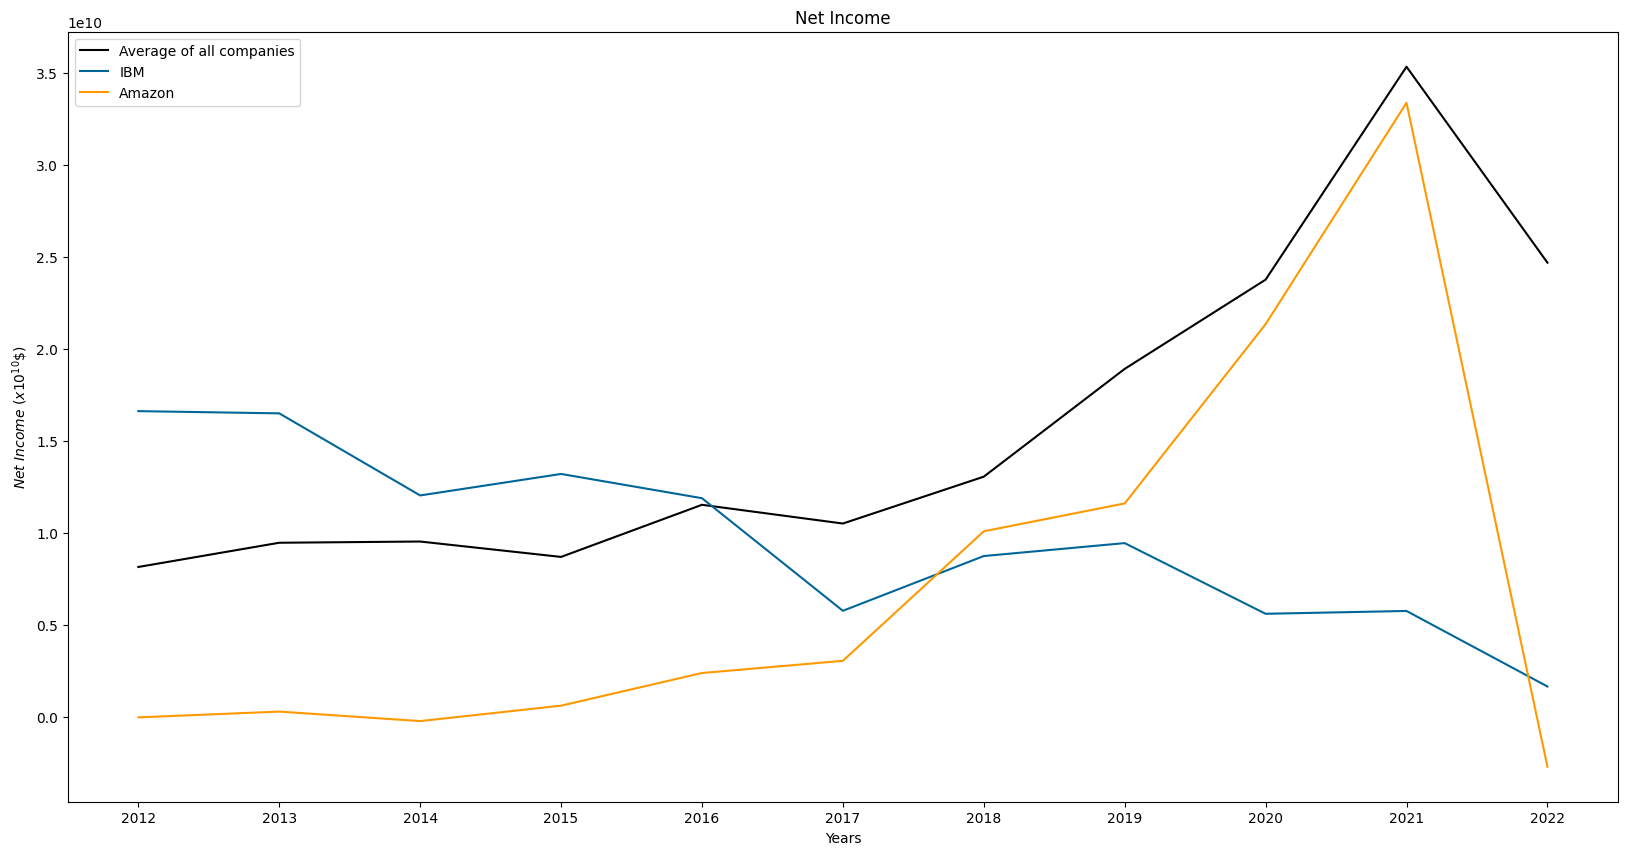

In [41]:
# Net Income
income_ax = sns.lineplot(x = 'Years', y = 'Net_Income', data = mean_df[['Years','Net_Income']], label = 'Average of all companies', color = 'black')
income_ax = sns.lineplot(x = 'Years', y = 'Net_Income', data = ibm_df[['Years','Net_Income']], label = 'IBM', color = '#006699')
income_ax = sns.lineplot(x = 'Years', y = 'Net_Income', data = amazon_df[['Years','Net_Income']], label = 'Amazon', color = '#FF9900')
income_ax.set(xticks = mean_df['Years'], title = 'Net Income', xlabel = 'Years', ylabel = "$Net\ Income\ (x10^{10}\$)$")
income_ax.legend()
plt.show()

### Gross Profit
Gross profit is a company's profits earned after subtracting the costs of producing and selling its products

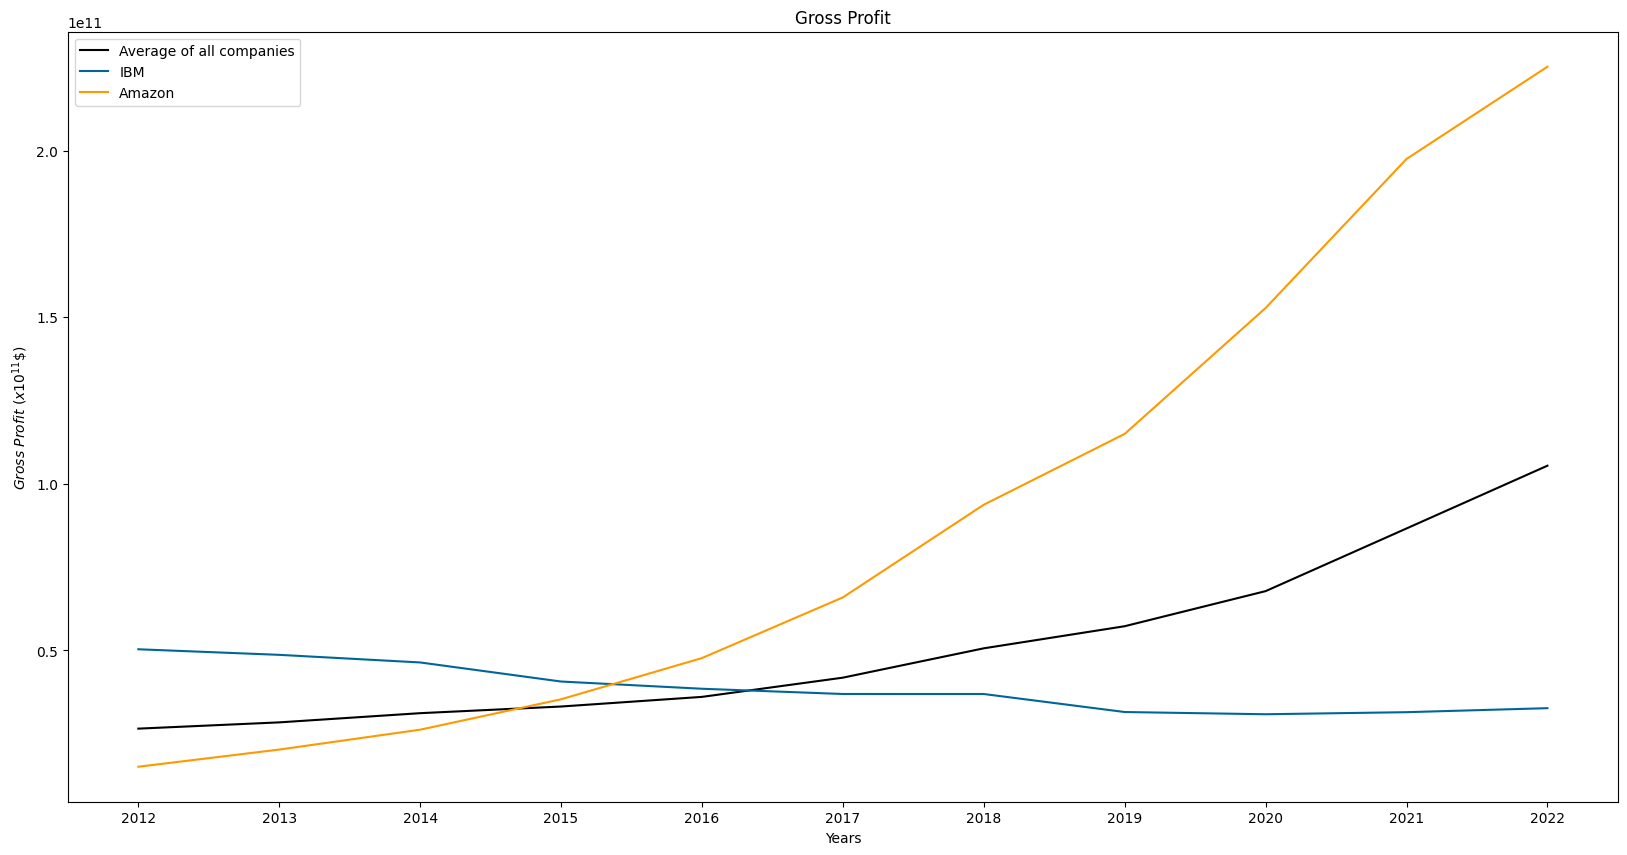

In [42]:
# Gross Profit
profit_ax = sns.lineplot(x = 'Years', y = 'Gross_Profit', data = mean_df[['Years','Gross_Profit']], label = 'Average of all companies', color = 'black')
profit_ax = sns.lineplot(x = 'Years', y = 'Gross_Profit', data = ibm_df[['Years','Gross_Profit']], label = 'IBM', color = '#006699')
profit_ax = sns.lineplot(x = 'Years', y = 'Gross_Profit', data = amazon_df[['Years','Gross_Profit']], label = 'Amazon', color = '#FF9900')
profit_ax.set(xticks = mean_df['Years'], title = 'Gross Profit', xlabel = 'Years', ylabel = "$Gross\ Profit\ (x10^{11}\$)$")
profit_ax.legend()
plt.show()

### Advertising Expenses
Graph showing the mean advertising expense between all the companies considered, IBM and Amazon.


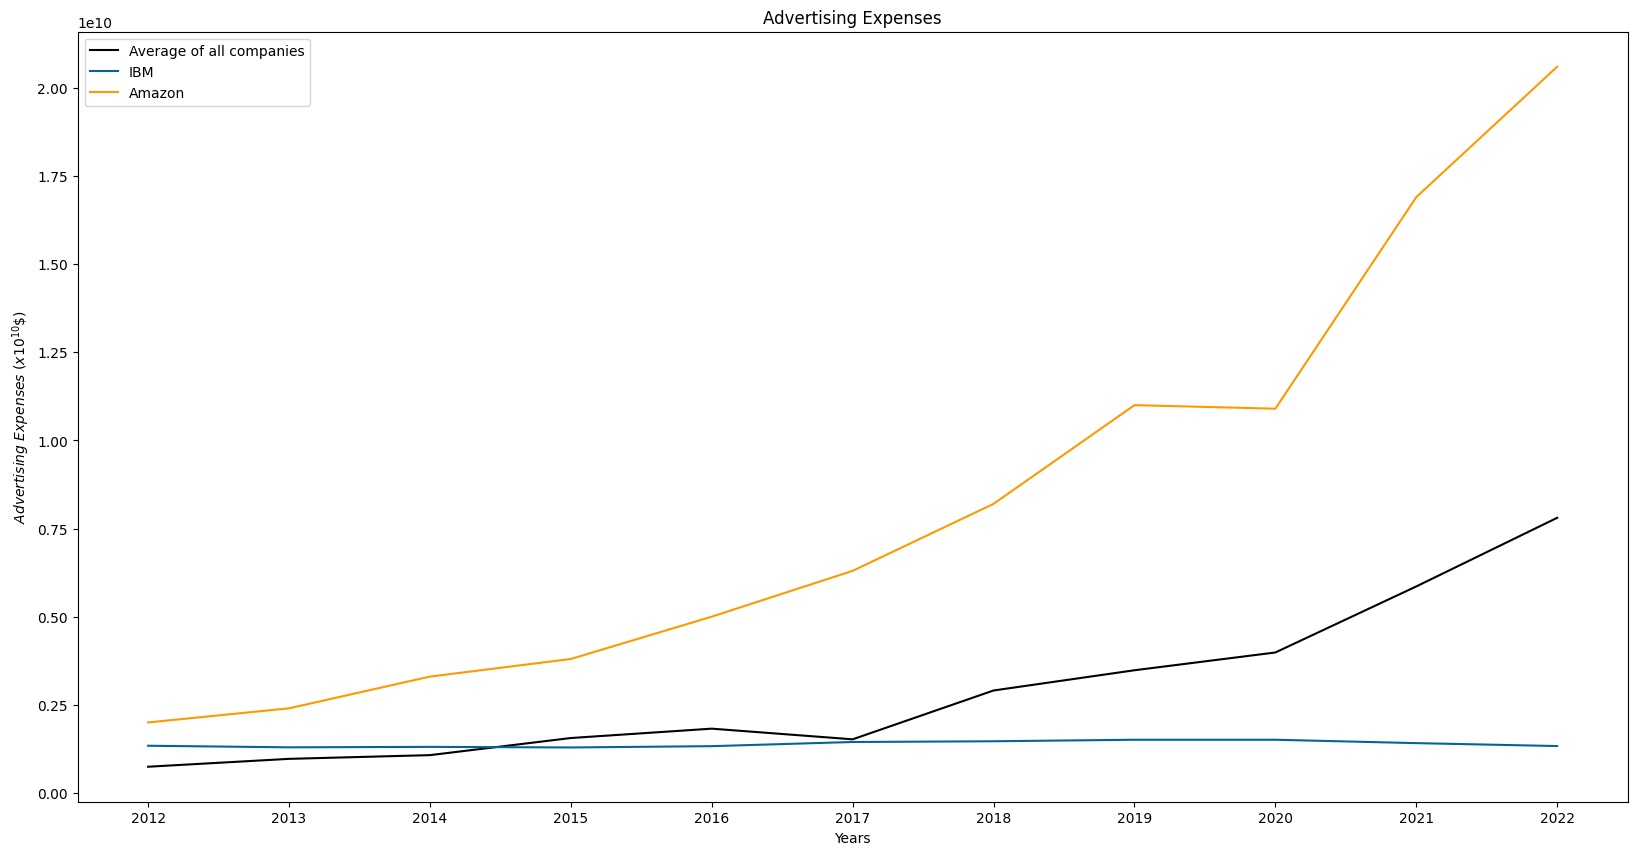

In [43]:
# Advertising Expense

adver_ax = sns.lineplot(x = 'Years', y = 'Advertising_Expense', data = mean_df[['Years','Advertising_Expense']], label = 'Average of all companies', color = 'black')
adver_ax = sns.lineplot(x = 'Years', y = 'Advertising_Expense', data = ibm_df[['Years','Advertising_Expense']], label = 'IBM', color = '#006699')
adver_ax = sns.lineplot(x = 'Years', y = 'Advertising_Expense', data = amazon_df[['Years','Advertising_Expense']], label = 'Amazon', color = '#FF9900')
adver_ax.set(xticks = mean_df['Years'], title = 'Advertising Expenses', xlabel = 'Years', ylabel = "$Advertising\ Expenses\ (x10^{10}\$)$")
adver_ax.legend()
plt.show()

### Research and Development Expenses
Graph showing the mean Research and Development expense between all the companies considered, IBM and Amazon.

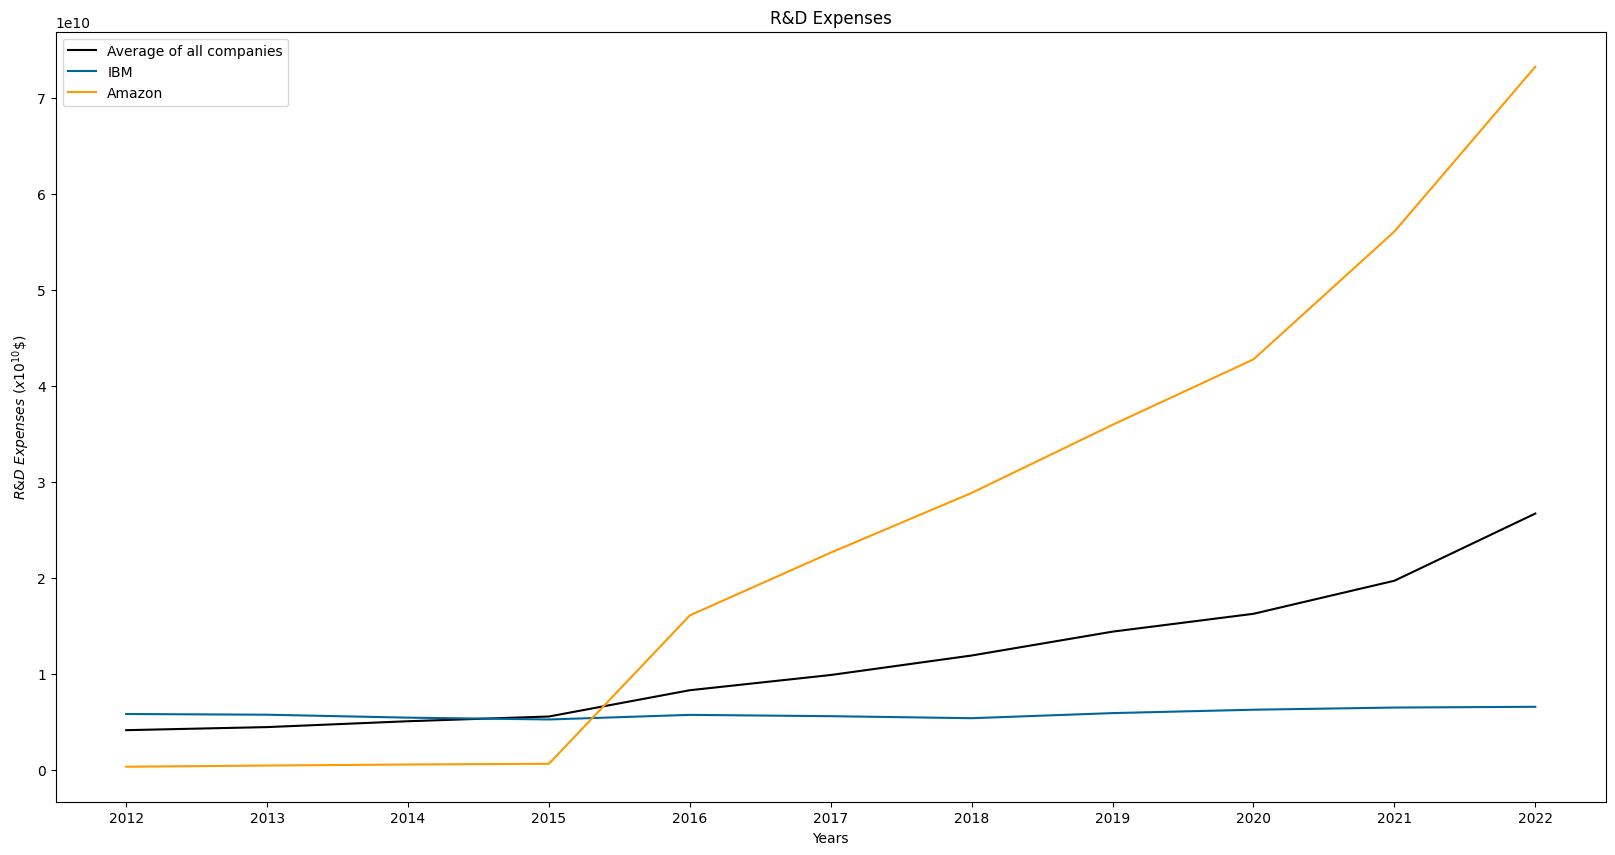

In [44]:
# R&D Expense
rd_ax = sns.lineplot(x = 'Years', y = 'RD_Expense', data = mean_df[['Years','RD_Expense']], label = 'Average of all companies', color = 'black')
rd_ax = sns.lineplot(x = 'Years', y = 'RD_Expense', data = ibm_df[['Years','RD_Expense']], label = 'IBM', color = '#006699')
rd_ax = sns.lineplot(x = 'Years', y = 'RD_Expense', data = amazon_df[['Years','RD_Expense']], label = 'Amazon', color = '#FF9900')
rd_ax.set(xticks = mean_df['Years'], title = 'R&D Expenses', xlabel = 'Years', ylabel = "$R&D\ Expenses\ (x10^{10}\$)$")
rd_ax.legend()
plt.show()

### Selling and Marketing Expenses
Graph showing the mean Selling and Marketing expense between all the companies considered, IBM and Amazon.

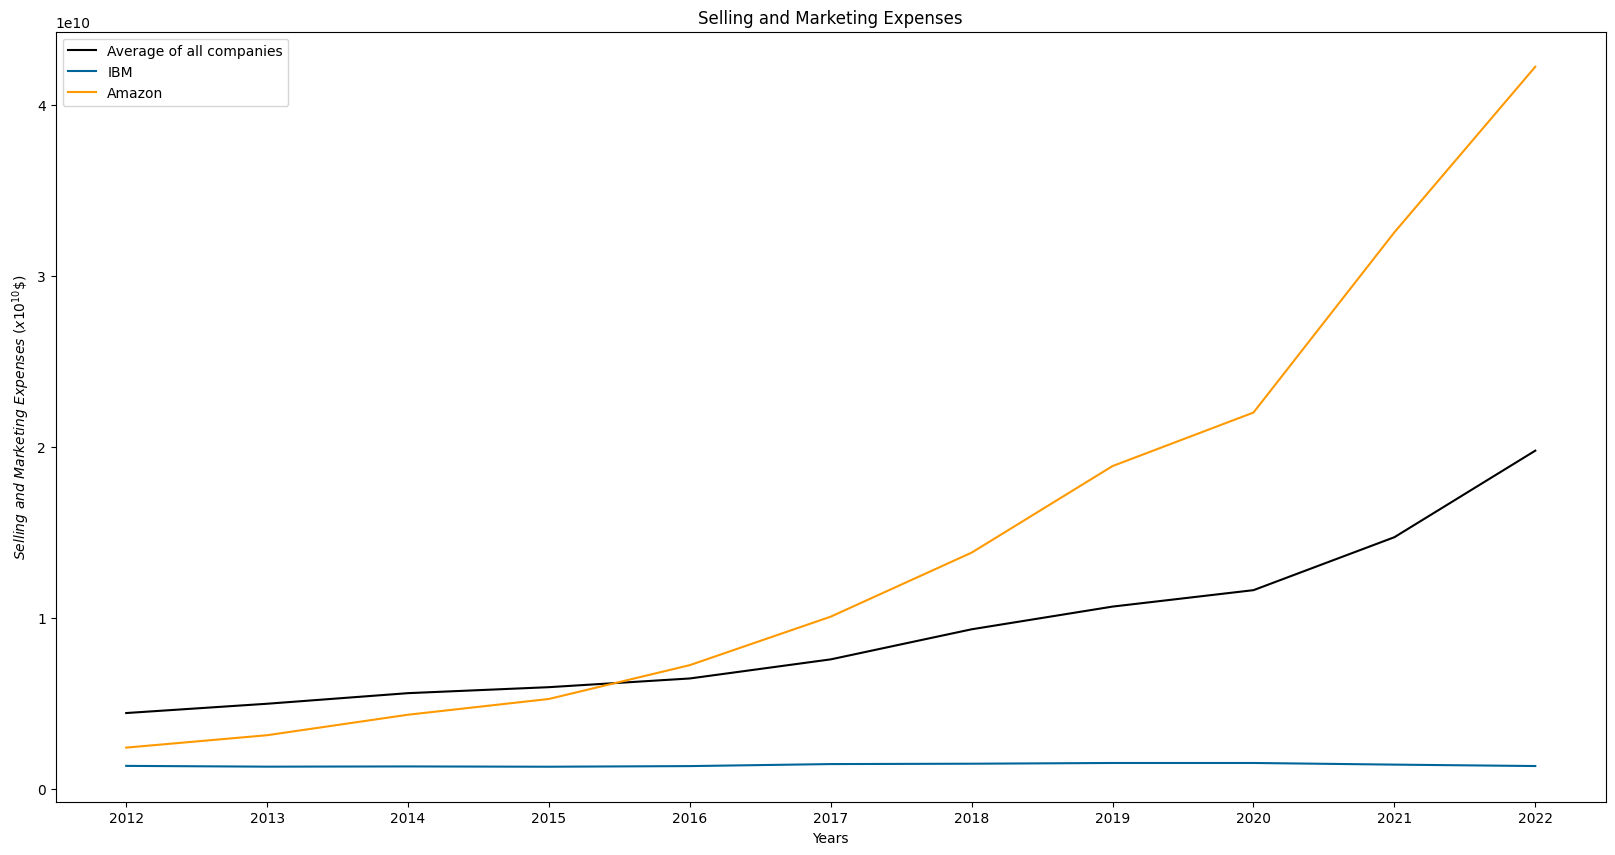

In [45]:
# S&M Expense
sm_ax = sns.lineplot(x = 'Years', y = 'Selling_and_Marketing_Expense', data = mean_df[['Years','Selling_and_Marketing_Expense']], label = 'Average of all companies', color = 'black')
sm_ax = sns.lineplot(x = 'Years', y = 'Selling_and_Marketing_Expense', data = ibm_df[['Years','Selling_and_Marketing_Expense']], label = 'IBM', color = '#006699')
sm_ax = sns.lineplot(x = 'Years', y = 'Selling_and_Marketing_Expense', data = amazon_df[['Years','Selling_and_Marketing_Expense']], label = "Amazon", color = '#FF9900')
sm_ax.set(xticks = mean_df['Years'], title = 'Selling and Marketing Expenses', xlabel = 'Years', ylabel = "$Selling\ and\ Marketing\ Expenses\ (x10^{10}\$)$")
sm_ax.legend()
plt.show()

### Number of Employees
Graph showing the mean number of employees between all the companies considered, IBM and Amazon.

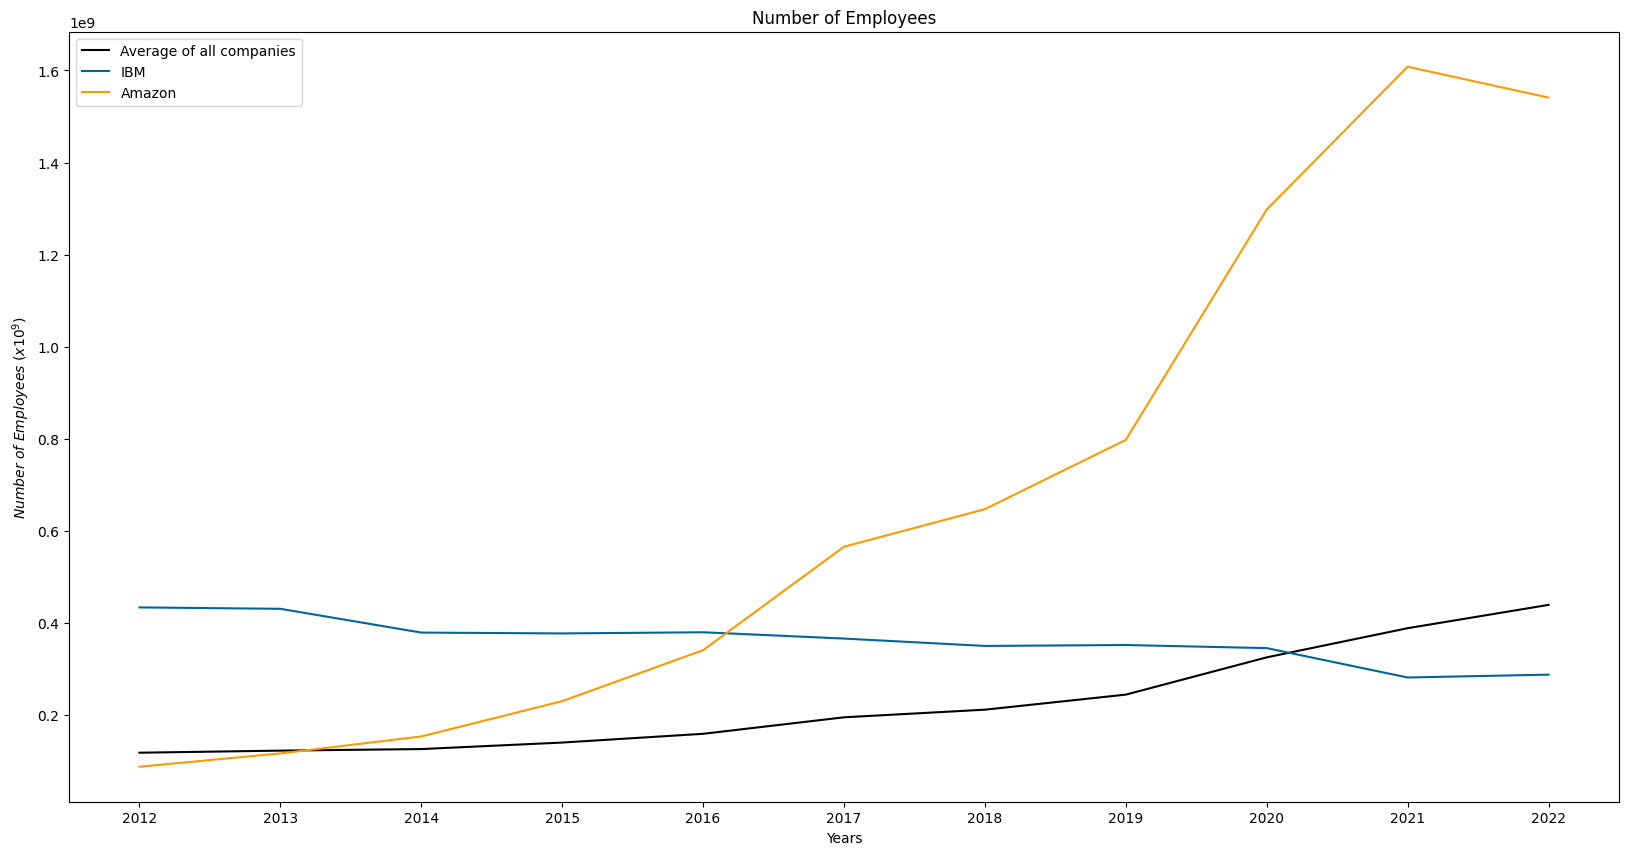

In [46]:
# Number of Employees
employees_ax = sns.lineplot(x = 'Years', y = 'No_of_Employees', data = mean_df[['Years','No_of_Employees']], label = 'Average of all companies', color = 'black')
employees_ax = sns.lineplot(x = 'Years', y = 'No_of_Employees', data = ibm_df[['Years','No_of_Employees']], label = 'IBM', color = '#006699')
employees_ax = sns.lineplot(x = 'Years', y = 'No_of_Employees', data = amazon_df[['Years','No_of_Employees']], label = 'Amazon', color = '#FF9900')
employees_ax.set(xticks = mean_df['Years'], title = 'Number of Employees', xlabel = 'Years', ylabel = "$Number\ of\ Employees\ (x10^{9})$")
employees_ax.legend()
plt.show()

### Correlation Analysis
Checking if there are any relationships between the columns. Positive values indicate that there is a direct relationship between the columns, and negative values indicate that there is a inverse relation between the columns.
<br>
The values in the matrix will always lie between -1 and 1. 0 indicates that there is no correlation. When the value tends to 1, then there is postitive corrleation and when it tends to -1 then there is negative correlation.

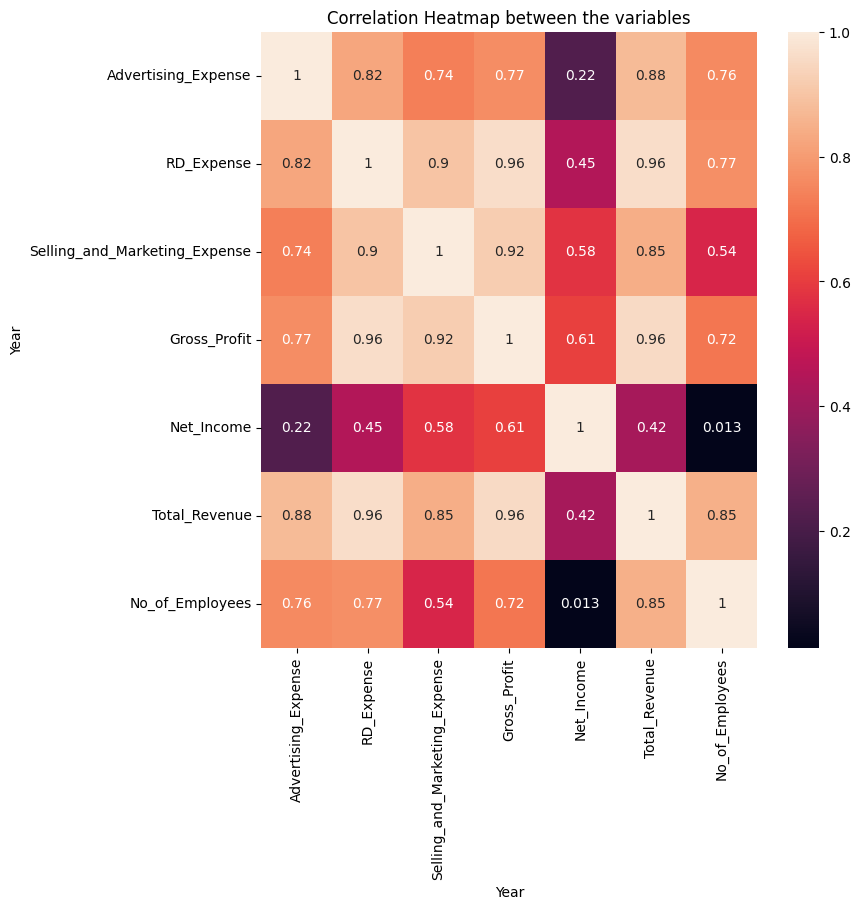

In [47]:
plt.rcParams['figure.figsize'] = (8,8)
exclude_cols = ['Years']
ax = sns.heatmap(final_df.drop(exclude_cols, axis = 1).corr(numeric_only = True), annot = True)
ax.set(title = 'Correlation Heatmap between the variables')
plt.show()

## Regression Analysis

### OLS Regression
Checking the relationship between Gross Profit, Selling and Marketing Expenses and Research and Development Expenses.

In [48]:
model = smf.ols(formula = "Gross_Profit ~ Selling_and_Marketing_Expense+RD_Expense", data=final_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Gross_Profit   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     616.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.90e-46
Time:                        15:31:05   Log-Likelihood:                -1860.2
No. Observations:                  76   AIC:                             3726.
Df Residuals:                      73   BIC:                             3733.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### Assumption 1 - Checking Linearity between dependent and each of independent variables

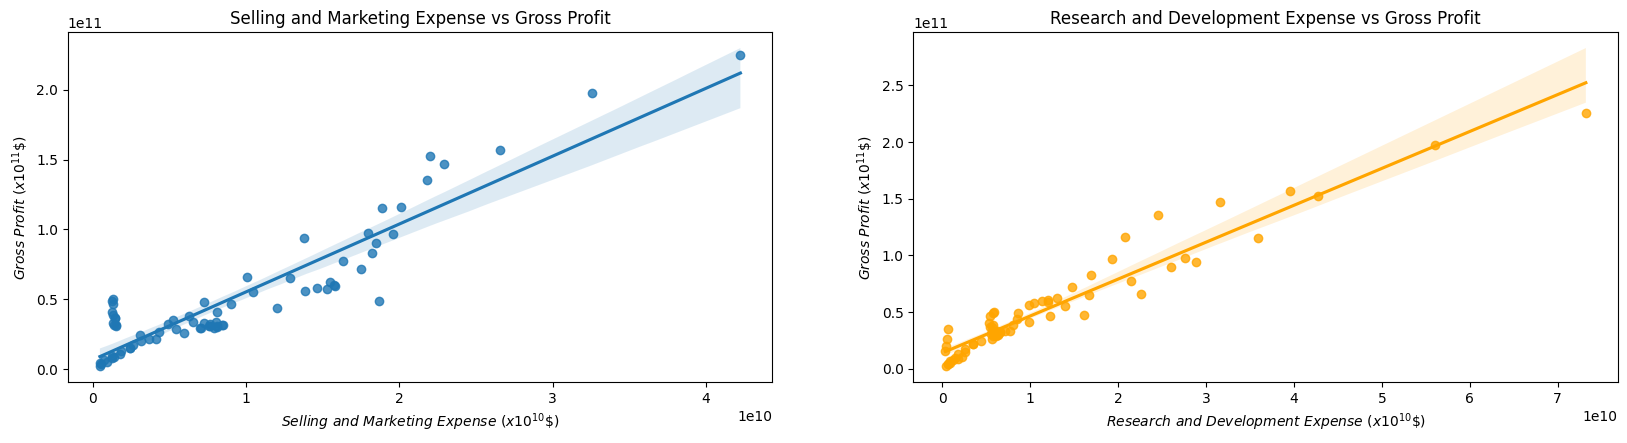

In [49]:
linearity_graphs = plt.figure(figsize = (20, 10))

linearity_graphs.add_subplot(2, 2, 1)
graph1 = sns.regplot(data=final_df, x='Selling_and_Marketing_Expense', y='Gross_Profit')
graph1.set(title = 'Selling and Marketing Expense vs Gross Profit', xlabel = "$Selling\ and\ Marketing\ Expense\ (x10^{10}\$)$", ylabel = "$Gross\ Profit\ (x10^{11}\$)$")

linearity_graphs.add_subplot(2,2,2)
graph2 = sns.regplot(data=final_df, x='RD_Expense', y='Gross_Profit', color='orange')
graph2.set(title = 'Research and Development Expense vs Gross Profit', xlabel = "$Research\ and\ Development\ Expense\ (x10^{10}\$)$", ylabel = "$Gross\ Profit\ (x10^{11}\$)$")
plt.show()

### Assumption 2 - Checking multicollinearity
VIF Scores are computed to check whether parameters are corelleated to each other.

In [50]:
vif_df = final_df[['RD_Expense','Selling_and_Marketing_Expense']]
vif_results = pd.DataFrame()

vif_results['feature'] = vif_df.columns
vif_results['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]

vif_results


,feature,VIF
0,RD_Expense,8.867344
1,Selling_and_Marketing_Expense,8.867344


### Assumption 3 - Plot of residuals
This is to check whether variance is normally distributed


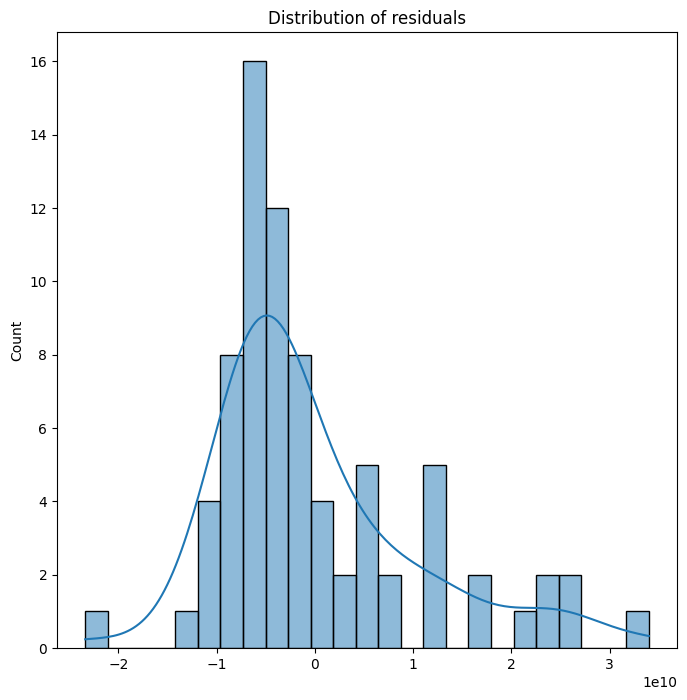

In [51]:
residual_plot = sns.histplot(results.resid, bins = 25, kde = True)
residual_plot.set(title = 'Distribution of residuals')
plt.show()

### Assumption 4: Check for homoscedasticity

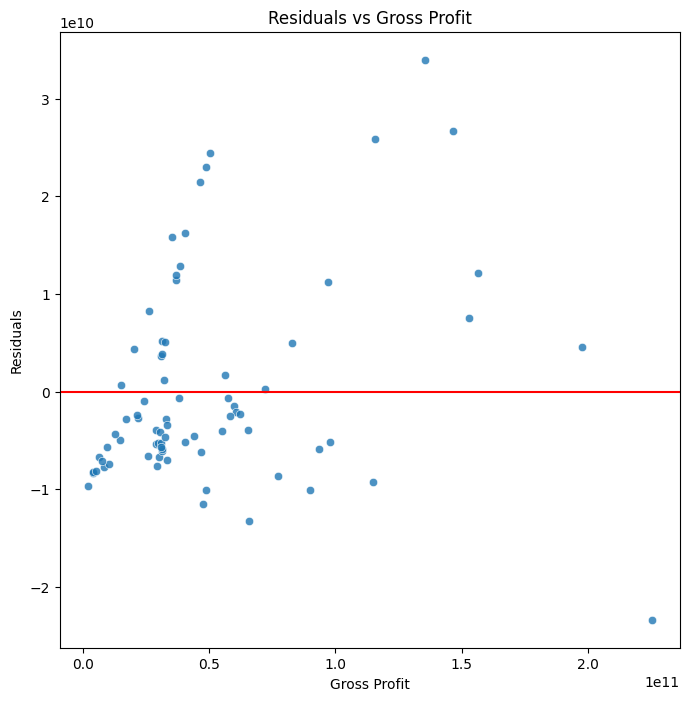

In [52]:
homoscedasticity_plot = sns.scatterplot(x=final_df['Gross_Profit'],y=results.resid, alpha=0.8)
homoscedasticity_plot.axhline(y=0,color='red')
homoscedasticity_plot.set(title='Residuals vs Gross Profit', xlabel = 'Gross Profit', ylabel = 'Residuals')
plt.show()

### Prediction
Using Linear Regression and Random Forest to check which has a higher R2 score and lower MSE

In [53]:
t = PrettyTable(['Method', 'R2 value', 'MSE value'])

X = final_df[['RD_Expense','Selling_and_Marketing_Expense']]
y = final_df['Gross_Profit']

# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)


# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)

t.add_row(['Linear Regression', linear_r2, linear_mse])



# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

t.add_row(['Random Forest', rf_r2, rf_mse])

print(t)



+-------------------+--------------------+------------------------+
|       Method      |      R2 value      |       MSE value        |
+-------------------+--------------------+------------------------+
| Linear Regression | 0.8324467891325081 | 1.8588036778349586e+20 |
|   Random Forest   | 0.9680142310057237 | 3.5484408049905906e+19 |
+-------------------+--------------------+------------------------+


### Predicton with actual values

Here, the values of R&D expenses and Selling and Marketing price of AWS from 2016, and seen where IBM could been.

In [54]:
x_topredict = amazon_df.loc[(amazon_df['Years'] >= 2016)][['RD_Expense','Selling_and_Marketing_Expense']]
y_ibmpred = rf_model.predict(x_topredict)
y_ibmpred

array([4.9253360e+10, 6.7891930e+10, 8.1332950e+10, 1.1194625e+11,
       1.4851585e+11, 1.8161164e+11, 2.0780753e+11])

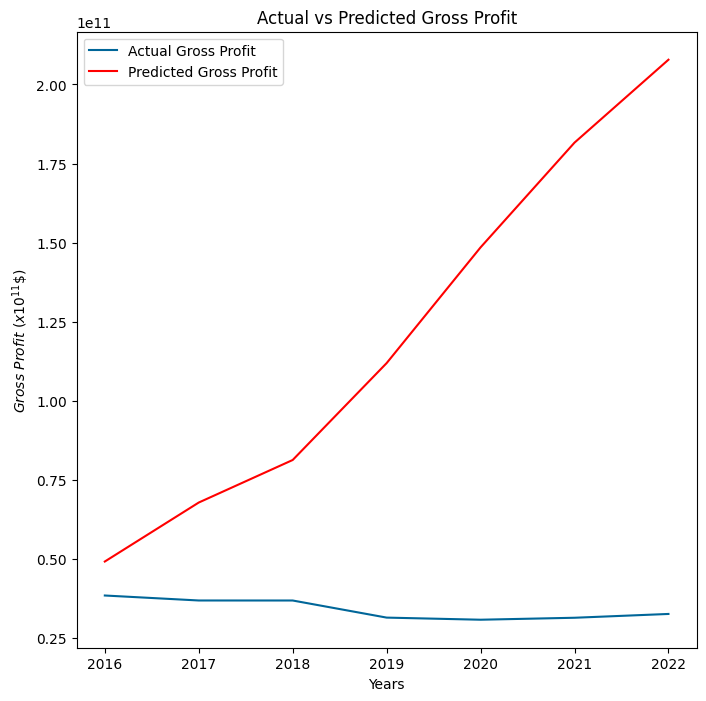

In [55]:
y_actualandpred = ibm_df.loc[(ibm_df['Years'] >= 2016)][['Years', 'Gross_Profit']].reset_index()
y_actualandpred['Predicted_Gross_Profit'] = pd.Series(y_ibmpred)
actualvspred = sns.lineplot(x = 'Years', y = 'Gross_Profit', data = y_actualandpred, label = 'Actual Gross Profit', color = '#006699')
actualvspred = sns.lineplot(x = 'Years', y = 'Predicted_Gross_Profit', data = y_actualandpred, label = 'Predicted Gross Profit', color = "red")
actualvspred.set(xticks = y_actualandpred['Years'], title = 'Actual vs Predicted Gross Profit', xlabel = 'Years', ylabel = "$Gross\ Profit\ (x10^{11}\$)$")
actualvspred.legend()
plt.show()
